# 0005.0000a Modeling Strategy a

In [1]:
import pathlib
import sys
import inspect
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 2
#add the 'src' directory to path to import modules
PROJECT_DIR = pathlib.Path.cwd().resolve().parent
sys.path.append(str(PROJECT_DIR))
%aimport
from src.visualization.visualize import extend_cols
from src.data.transform_long_to_wide import run_transform_ts_to_supervised
from src.data.transformed_to_all_stacked import transformed_to_all_stacked
from src.data.stacked_to_ts_featured import clean_df

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

SAMPLE_DIR = PROJECT_DIR / 'data' / 'sample'
SAMP_STACKED_DIR = SAMPLE_DIR / '01-stacked-seasons'
SAMP_FEATURED_DIR = SAMPLE_DIR / '02-featured'
SAMP_TRANSFORMED_DIR = SAMPLE_DIR / '03-transformed'

SAMP_STACKED_FP = SAMP_STACKED_DIR / 'germany' / 'bundesliga' / '2007-2008__2009-2010.csv'
SAMP_FEATURED_FP = SAMP_FEATURED_DIR / 'germany' / 'bundesliga' / '2007-2008__2009-2010.csv'
SAMP_TRANSFORMED_FP = SAMP_TRANSFORMED_DIR / 'germany' / 'bundesliga' / '2007-2008__2009-2010.csv'
SAMP_MODEL_FP = SAMPLE_DIR / 'models' / 'optimized-model.joblib'

Modules to reload:
all-except-skipped

Modules to skip:



## Modeling Strategy

1. Review Starting Data, Directory Structure

2. Prepare for Modeling, Add some Features, Place into "featured" Directory 

3. Review the Features

4. Transform the Data from Time-Series to Supervised

5. Review the Transformed Data

6. Model the Transformed Data

7. Score the Model with various parameters

8. Calculate the betting return

## 1. Review Starting Data, Directory Structure

A sample directory is set up which contains a subset of the data

The directory is shown below

In [2]:
SAMP_FEATURED_SUBDIRS  = str(SAMP_FEATURED_DIR) + '/*/'
SAMP_TRANSFORMED_SUBDIRS = str(SAMP_TRANSFORMED_DIR) + '/*/' 

In [3]:
!rm -rf $SAMP_FEATURED_SUBDIRS
!rm -rf $SAMP_TRANSFORMED_SUBDIRS
!tree $SAMPLE_DIR -n

/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/sample
├── 01-stacked-seasons
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2009-2010.csv
├── 02-featured
├── 03-transformed
├── 04-all-stacked
└── models

7 directories, 1 file


In [4]:
df_season_stacked = pd.read_csv(SAMP_STACKED_FP,
                                parse_dates=['date']).sort_values(by=['date', 'h', 'a']).reset_index(drop=True)
df_season_stacked.shape

(918, 94)

DataFrame is a bit difficult to read because it is so wide

It contains some additional columns that we are not using in this particular analysis such as asian odds and Goal difference odds.

These are dropped and the Dataframe is put into a clearer order using a utility function `clean_df`

In [5]:
df_season_stacked = clean_df(df_season_stacked)
df_season_stacked.head()

KeyError: "['implied_hwin', 'implied_awin', 'implied_draw', 'seasonPercentile'] not in index"

## 2. Prepare for Modeling, Add Some Features, Place into "featured" Directory

#### Utilities

+ One hot encode the results column
+ Make a generic Odds Column - hwinOdds, drawOdds, AwinOdds using Bet365 data
+ Add a game day to use in splitting the season for modeling
    + Walk through each game day
    + Games before game daya are used as features
    + game day games are predicted on by the model
+ Add a marker to show the percentile of the season completed

#### Features

+ Run a Poisson Regression through the season, using historical goals scored as inputs

This is acheived using the src code, which is not shown in this Notebook

The src code runs by moving data through a series of defined directories - defined as constants

We override the directory constants below, so we can run the code on the sample directories


In [6]:
from src.data import stacked_to_ts_featured as sttf
sttf.STACKED_DIR = SAMP_STACKED_DIR
sttf.FEATURED_DIR = SAMP_FEATURED_DIR
sttf.apply_ts_features()

/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:521: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:428: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:134: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:134: RuntimeWarning: divide by zero en

KeyError: "['implied_hwin', 'implied_awin', 'implied_draw'] not in index"

## 3. Review the Features

In [ ]:
!tree $SAMPLE_DIR -n

In [8]:
df_featured = pd.read_csv(SAMP_FEATURED_FP,
                          parse_dates=['date']).sort_values(by=['date', 'h', 'a']).reset_index(drop=True)
df_featured.shape

(918, 47)

In [9]:
df_featured.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,h_corners,h_fouls,h_htGoals,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,a_corners,a_fouls,a_htGoals,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOddsBbMax,awinOddsBbMean,awinOdds,awinOddsBwa,awinOddsIw,awinOddsLb,drawOddsBbMax,drawOddsBbMean,drawOdds,drawOddsBwa,drawOddsIw,drawOddsLb,hwinOddsBbMax,hwinOddsBbMean,hwinOdds,hwinOddsBwa,hwinOddsIw,hwinOddsLb
0,germany,bundesliga,2007-2008,stuttgart,schalke,2007-08-10,2.0,2.0,draw,9.0,19.0,0.0,NaN,NaN,NaN,0.0,16.0,7.0,4.0,0.0,23.0,1.0,NaN,NaN,NaN,0.0,10.0,4.0,3.0,3.20,2.92,2.87,2.85,2.8,3.0,3.30,3.18,3.25,3.20,3.1,3.20,2.55,2.30,2.37,2.30,2.3,2.10
1,germany,bundesliga,2007-2008,bayern-munich,hansa-rostock,2007-08-11,3.0,0.0,hwin,4.0,14.0,1.0,NaN,NaN,NaN,0.0,27.0,13.0,0.0,1.0,13.0,0.0,NaN,NaN,NaN,0.0,6.0,0.0,3.0,21.00,13.40,19.00,12.25,11.0,11.0,6.80,5.89,6.00,6.75,5.2,5.00,1.20,1.18,1.16,1.15,1.2,1.20
2,germany,bundesliga,2007-2008,bochum,sv-werder-bremen,2007-08-11,2.0,2.0,draw,7.0,15.0,0.0,NaN,NaN,NaN,0.0,17.0,4.0,1.0,6.0,17.0,2.0,NaN,NaN,NaN,0.0,20.0,9.0,2.0,2.22,1.99,2.05,1.90,2.1,2.0,3.40,3.24,3.30,3.25,3.1,3.20,3.75,3.44,3.50,3.70,3.2,3.20
3,germany,bundesliga,2007-2008,eintracht-frankfurt,hertha-berlin,2007-08-11,1.0,0.0,hwin,6.0,13.0,1.0,NaN,NaN,NaN,0.0,19.0,5.0,2.0,5.0,13.0,0.0,NaN,NaN,NaN,0.0,10.0,3.0,1.0,3.30,2.86,2.90,2.85,3.0,2.6,3.30,3.18,3.20,3.20,3.1,3.20,2.50,2.33,2.37,2.30,2.2,2.37
4,germany,bundesliga,2007-2008,hannover,hamburger-sv,2007-08-11,0.0,1.0,awin,6.0,20.0,0.0,NaN,NaN,NaN,0.0,10.0,2.0,3.0,4.0,18.0,1.0,NaN,NaN,NaN,0.0,14.0,8.0,1.0,2.85,2.60,2.75,2.60,2.6,2.4,3.25,3.17,3.20,3.05,3.1,3.25,2.80,2.55,2.50,2.60,2.5,2.50


In [10]:
df_featured.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 47 columns):
nation             918 non-null object
league             918 non-null object
season             918 non-null object
h                  918 non-null object
a                  918 non-null object
date               918 non-null datetime64[ns]
h_ftGoals          918 non-null float64
a_ftGoals          918 non-null float64
result             918 non-null object
h_corners          918 non-null float64
h_fouls            918 non-null float64
h_htGoals          918 non-null float64
h_poissDraw        845 non-null float64
h_poissLose        845 non-null float64
h_poissWin         845 non-null float64
h_redCards         918 non-null float64
h_shots            918 non-null float64
h_shotsOnTarget    918 non-null float64
h_yellowCards      918 non-null float64
a_corners          918 non-null float64
a_fouls            918 non-null float64
a_htGoals          918 non-null float64
a_poissDraw   

We want our poisson regression probabailities to be tretaed as features when we transform the data.

The code treats a column as a feature if it is prefixed by `h_` or `a_`

Therefore we need to add this prefix

In the production version of the PoissonRegression Classifier these prefixed columns will be returned

We gave 3 probabilities associated with 2 teams. One of the probabilities applies to both team - the draw probability - Explain here !!!!!!!!!!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

therefore, we will end up with each team having 2 probabilities as features - win and draw - enumerated below

Home Team
+ p(win) h_poissWin
+ p(draw) h_poissDraw
+ p(lose) h_poissLose

Away Team
+ p(win) a_poissWin
+ p(draw) a_poissDraw
+ p(lose) a_poissLose


## 4. Transform the Featured Data from Time-Series to Supervised


The source code is built to run on specific directories e.g. FEATURED_DIR, TRANSFORMED_DIR - see below - these are python CONSTANTS

We will override these constants so we can use the same module on our sample data

Below, we can see the main function we will run on the dataframe we created above

The function that does the work is transform_ts_to_supervised

In [11]:
from src.data import transform_long_to_wide
transform_long_to_wide.FEATURED_DIR = SAMP_FEATURED_DIR
transform_long_to_wide.TRANSFORMED_DIR = SAMP_TRANSFORMED_DIR

In [12]:
run_transform_ts_to_supervised()

1


In [13]:
!tree $SAMPLE_DIR -n

/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/sample
├── 01-stacked-seasons
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2009-2010.csv
├── 02-featured
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2009-2010.csv
├── 03-transformed
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2009-2010.csv
└── models

10 directories, 3 files


# 5. Review the Transformed Data

In [14]:
df_trans = pd.read_csv(SAMP_TRANSFORMED_FP,
                       parse_dates=['date']).sort_values(by=['date', 'h', 'a']).reset_index(drop=True)
# Sort the features

In [15]:
df_trans.head(2)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBbMax,awinOddsBbMean,awinOddsBwa,awinOddsIw,awinOddsLb,drawOdds,drawOddsBbMax,drawOddsBbMean,drawOddsBwa,drawOddsIw,drawOddsLb,h_corners,h_fouls,h_htGoals,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBbMax,hwinOddsBbMean,hwinOddsBwa,hwinOddsIw,hwinOddsLb,a_a_corners-0,a_a_corners-1,a_a_corners-2,a_a_corners-3,a_a_corners-4,a_a_corners-5,a_a_corners-6,a_a_corners-7,a_a_corners-8,a_a_corners-9,a_a_corners-10,a_a_corners-11,a_a_corners-12,a_a_corners-13,a_a_corners-14,a_a_corners-15,a_a_corners-16,a_a_fouls-0,a_a_fouls-1,a_a_fouls-2,a_a_fouls-3,a_a_fouls-4,a_a_fouls-5,a_a_fouls-6,a_a_fouls-7,a_a_fouls-8,a_a_fouls-9,a_a_fouls-10,a_a_fouls-11,a_a_fouls-12,a_a_fouls-13,a_a_fouls-14,a_a_fouls-15,a_a_fouls-16,a_a_ftGoals-0,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_a_ftGoals-9,a_a_ftGoals-10,a_a_ftGoals-11,a_a_ftGoals-12,a_a_ftGoals-13,a_a_ftGoals-14,a_a_ftGoals-15,a_a_ftGoals-16,a_a_htGoals-0,a_a_htGoals-1,a_a_htGoals-2,a_a_htGoals-3,a_a_htGoals-4,a_a_htGoals-5,a_a_htGoals-6,a_a_htGoals-7,a_a_htGoals-8,a_a_htGoals-9,a_a_htGoals-10,a_a_htGoals-11,a_a_htGoals-12,a_a_htGoals-13,a_a_htGoals-14,a_a_htGoals-15,a_a_htGoals-16,a_a_poissDraw-0,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissDraw-3,a_a_poissDraw-4,a_a_poissDraw-5,a_a_poissDraw-6,a_a_poissDraw-7,a_a_poissDraw-8,a_a_poissDraw-9,a_a_poissDraw-10,a_a_poissDraw-11,a_a_poissDraw-12,a_a_poissDraw-13,a_a_poissDraw-14,a_a_poissDraw-15,a_a_poissDraw-16,a_a_poissLose-0,a_a_poissLose-1,a_a_poissLose-2,a_a_poissLose-3,a_a_poissLose-4,a_a_poissLose-5,a_a_poissLose-6,a_a_poissLose-7,a_a_poissLose-8,a_a_poissLose-9,a_a_poissLose-10,a_a_poissLose-11,a_a_poissLose-12,a_a_poissLose-13,a_a_poissLose-14,a_a_poissLose-15,a_a_poissLose-16,a_a_poissWin-0,a_a_poissWin-1,a_a_poissWin-2,a_a_poissWin-3,a_a_poissWin-4,a_a_poissWin-5,a_a_poissWin-6,a_a_poissWin-7,a_a_poissWin-8,a_a_poissWin-9,a_a_poissWin-10,a_a_poissWin-11,a_a_poissWin-12,a_a_poissWin-13,a_a_poissWin-14,a_a_poissWin-15,a_a_poissWin-16,a_a_redCards-0,a_a_redCards-1,a_a_redCards-2,a_a_redCards-3,a_a_redCards-4,a_a_redCards-5,a_a_redCards-6,a_a_redCards-7,a_a_redCards-8,a_a_redCards-9,a_a_redCards-10,a_a_redCards-11,a_a_redCards-12,a_a_redCards-13,a_a_redCards-14,a_a_redCards-15,a_a_redCards-16,a_a_shots-0,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_a_shots-8,a_a_shots-9,a_a_shots-10,a_a_shots-11,a_a_shots-12,a_a_shots-13,a_a_shots-14,a_a_shots-15,a_a_shots-16,a_a_shotsOnTarget-0,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_a_shotsOnTarget-8,a_a_shotsOnTarget-9,a_a_shotsOnTarget-10,a_a_shotsOnTarget-11,a_a_shotsOnTarget-12,a_a_shotsOnTarget-13,a_a_shotsOnTarget-14,a_a_shotsOnTarget-15,a_a_shotsOnTarget-16,a_a_yellowCards-0,a_a_yellowCards-1,a_a_yellowCards-2,a_a_yellowCards-3,a_a_yellowCards-4,a_a_yellowCards-5,a_a_yellowCards-6,a_a_yellowCards-7,a_a_yellowCards-8,a_a_yellowCards-9,a_a_yellowCards-10,a_a_yellowCards-11,a_a_yellowCards-12,a_a_yellowCards-13,a_a_yellowCards-14,a_a_yellowCards-15,a_a_yellowCards-16,a_h_corners-1,a_h_corners-2,a_h_corners-3,a_h_corners-4,a_h_corners-5,a_h_corners-6,a_h_corners-7,a_h_corners-8,a_h_corners-9,a_h_corners-10,a_h_corners-11,a_h_corners-12,a_h_corners-13,a_h_corners-14,a_h_corners-15,a_h_corners-16,...,h_a_redCards-6,h_a_redCards-7,h_a_redCards-8,h_a_redCards-9,h_a_redCards-10,h_a_redCards-11,h_a_redCards-12,h_a_redCards-13,h_a_redCards-14,h_a_redCards-15,h_a_redCards-16,h_a_redCards-17,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_a_shots-7,h_a_shots-8,h_a_shots-9,h_a_shots-10,h_a_shots-11,h_a_shots-12,h_a_shots-13,h_a_shots-14,h_a_sho

We have these historical features for each team playing a match

So, consider a mtach being played today

To get the **number of goals** scored by the **home team** in the **last 2 games** they played **at home**:
+ h_h_ftGoals-1
+ h_h_ftGoals-2

To get the **number of goals** scored by the **home team** in the **last 3 games** they played **away**:
+ h_a_ftGoals-1
+ h_a_ftGoals-2
+ h_a_ftGoals-3

To get the **poisson regression probability of winning** for the **away team** in the **last (1) game** they played **away**:
+ a_a_poissWin-1

Feature Nomenclature & Time Series to Supervised

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

https://machinelearningmastery.com/time-series-forecasting-supervised-learning/

DataFrame in time sequence where index 0 is the earliest game, and index max is the latest game

There are 2 teams per game `h` and `a`, where h indicates the team played at home, and a - away.

Each team has generated a feature by the end of the game - `h_feat`, and `a_feat`

There could be multiple features, meaning a double  set for each feature

Each team has a home game record and an away game record

So, there are 4 records to get for each feature
+ home team home record `h_h`
+ home team away record `h_a`
+ away team home record `a_h`
+ away team away record `a_a`

Results presented as 0, -1, -2 ... -n where 0 referes to the current game. This column can be used as a predictor variable for classification, or used as a classification response, or dropped and just the previous game features used for prediction

### Interpretation Note

`h_h_feat_-1` means:
+ (`h`) home team 
+ (`h`) home game records 
+ (`feat`) feature value in 
+ (`-1`) last game


In [16]:
df_trans.tail(2)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBbMax,awinOddsBbMean,awinOddsBwa,awinOddsIw,awinOddsLb,drawOdds,drawOddsBbMax,drawOddsBbMean,drawOddsBwa,drawOddsIw,drawOddsLb,h_corners,h_fouls,h_htGoals,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBbMax,hwinOddsBbMean,hwinOddsBwa,hwinOddsIw,hwinOddsLb,a_a_corners-0,a_a_corners-1,a_a_corners-2,a_a_corners-3,a_a_corners-4,a_a_corners-5,a_a_corners-6,a_a_corners-7,a_a_corners-8,a_a_corners-9,a_a_corners-10,a_a_corners-11,a_a_corners-12,a_a_corners-13,a_a_corners-14,a_a_corners-15,a_a_corners-16,a_a_fouls-0,a_a_fouls-1,a_a_fouls-2,a_a_fouls-3,a_a_fouls-4,a_a_fouls-5,a_a_fouls-6,a_a_fouls-7,a_a_fouls-8,a_a_fouls-9,a_a_fouls-10,a_a_fouls-11,a_a_fouls-12,a_a_fouls-13,a_a_fouls-14,a_a_fouls-15,a_a_fouls-16,a_a_ftGoals-0,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_a_ftGoals-9,a_a_ftGoals-10,a_a_ftGoals-11,a_a_ftGoals-12,a_a_ftGoals-13,a_a_ftGoals-14,a_a_ftGoals-15,a_a_ftGoals-16,a_a_htGoals-0,a_a_htGoals-1,a_a_htGoals-2,a_a_htGoals-3,a_a_htGoals-4,a_a_htGoals-5,a_a_htGoals-6,a_a_htGoals-7,a_a_htGoals-8,a_a_htGoals-9,a_a_htGoals-10,a_a_htGoals-11,a_a_htGoals-12,a_a_htGoals-13,a_a_htGoals-14,a_a_htGoals-15,a_a_htGoals-16,a_a_poissDraw-0,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissDraw-3,a_a_poissDraw-4,a_a_poissDraw-5,a_a_poissDraw-6,a_a_poissDraw-7,a_a_poissDraw-8,a_a_poissDraw-9,a_a_poissDraw-10,a_a_poissDraw-11,a_a_poissDraw-12,a_a_poissDraw-13,a_a_poissDraw-14,a_a_poissDraw-15,a_a_poissDraw-16,a_a_poissLose-0,a_a_poissLose-1,a_a_poissLose-2,a_a_poissLose-3,a_a_poissLose-4,a_a_poissLose-5,a_a_poissLose-6,a_a_poissLose-7,a_a_poissLose-8,a_a_poissLose-9,a_a_poissLose-10,a_a_poissLose-11,a_a_poissLose-12,a_a_poissLose-13,a_a_poissLose-14,a_a_poissLose-15,a_a_poissLose-16,a_a_poissWin-0,a_a_poissWin-1,a_a_poissWin-2,a_a_poissWin-3,a_a_poissWin-4,a_a_poissWin-5,a_a_poissWin-6,a_a_poissWin-7,a_a_poissWin-8,a_a_poissWin-9,a_a_poissWin-10,a_a_poissWin-11,a_a_poissWin-12,a_a_poissWin-13,a_a_poissWin-14,a_a_poissWin-15,a_a_poissWin-16,a_a_redCards-0,a_a_redCards-1,a_a_redCards-2,a_a_redCards-3,a_a_redCards-4,a_a_redCards-5,a_a_redCards-6,a_a_redCards-7,a_a_redCards-8,a_a_redCards-9,a_a_redCards-10,a_a_redCards-11,a_a_redCards-12,a_a_redCards-13,a_a_redCards-14,a_a_redCards-15,a_a_redCards-16,a_a_shots-0,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_a_shots-8,a_a_shots-9,a_a_shots-10,a_a_shots-11,a_a_shots-12,a_a_shots-13,a_a_shots-14,a_a_shots-15,a_a_shots-16,a_a_shotsOnTarget-0,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_a_shotsOnTarget-8,a_a_shotsOnTarget-9,a_a_shotsOnTarget-10,a_a_shotsOnTarget-11,a_a_shotsOnTarget-12,a_a_shotsOnTarget-13,a_a_shotsOnTarget-14,a_a_shotsOnTarget-15,a_a_shotsOnTarget-16,a_a_yellowCards-0,a_a_yellowCards-1,a_a_yellowCards-2,a_a_yellowCards-3,a_a_yellowCards-4,a_a_yellowCards-5,a_a_yellowCards-6,a_a_yellowCards-7,a_a_yellowCards-8,a_a_yellowCards-9,a_a_yellowCards-10,a_a_yellowCards-11,a_a_yellowCards-12,a_a_yellowCards-13,a_a_yellowCards-14,a_a_yellowCards-15,a_a_yellowCards-16,a_h_corners-1,a_h_corners-2,a_h_corners-3,a_h_corners-4,a_h_corners-5,a_h_corners-6,a_h_corners-7,a_h_corners-8,a_h_corners-9,a_h_corners-10,a_h_corners-11,a_h_corners-12,a_h_corners-13,a_h_corners-14,a_h_corners-15,a_h_corners-16,...,h_a_redCards-6,h_a_redCards-7,h_a_redCards-8,h_a_redCards-9,h_a_redCards-10,h_a_redCards-11,h_a_redCards-12,h_a_redCards-13,h_a_redCards-14,h_a_redCards-15,h_a_redCards-16,h_a_redCards-17,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_a_shots-7,h_a_shots-8,h_a_shots-9,h_a_shots-10,h_a_shots-11,h_a_shots-12,h_a_shots-13,h_a_shots-14,h_a_sho

## 6. Stack All Data for Modeling

In [17]:
df_trans.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 789 columns):
nation                  918 non-null object
league                  918 non-null object
season                  918 non-null object
h                       918 non-null object
a                       918 non-null object
date                    918 non-null datetime64[ns]
h_ftGoals               918 non-null float64
a_ftGoals               918 non-null float64
result                  918 non-null object
a_corners               918 non-null float64
a_fouls                 918 non-null float64
a_htGoals               918 non-null float64
a_poissDraw             845 non-null float64
a_poissLose             845 non-null float64
a_poissWin              845 non-null float64
a_redCards              918 non-null float64
a_shots                 918 non-null float64
a_shotsOnTarget         918 non-null float64
a_yellowCards           918 non-null float64
awinOdds                918 non-null f

As the season progresses, more historical data becomes available, which is seen in the missing data plot below

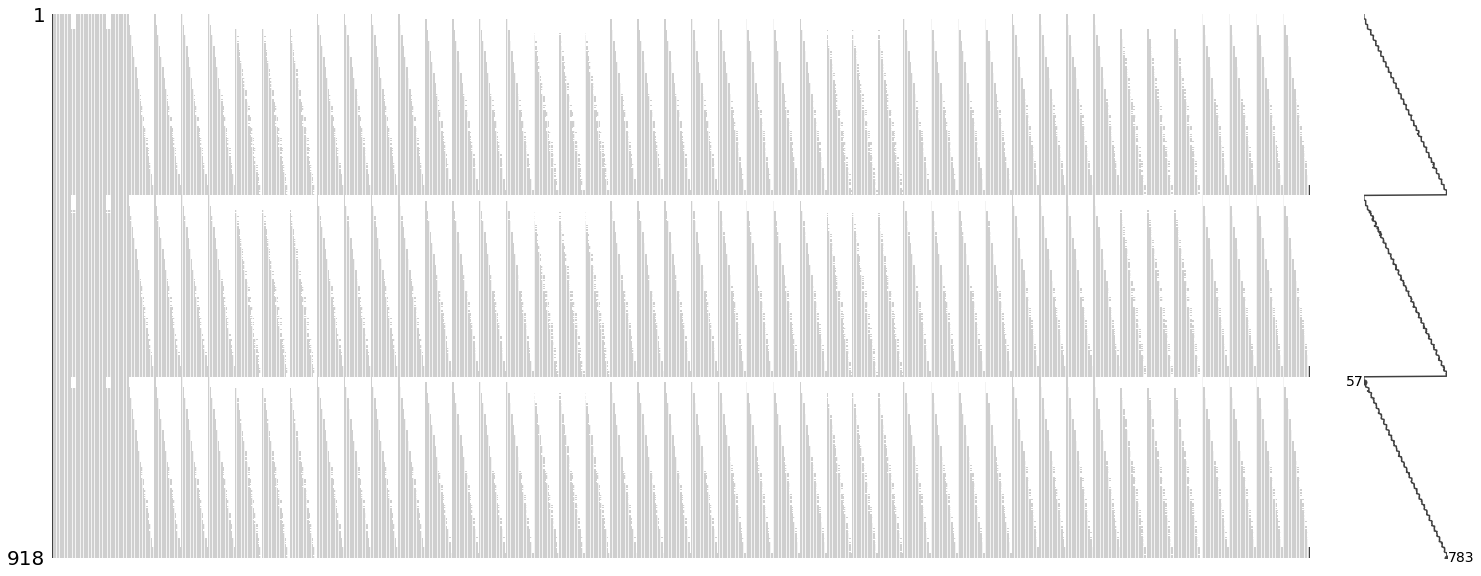

In [18]:
msno.matrix(df_trans)
plt.show();

Reviewing a single feature

As the season progresses, more historical data builds up, and the row fills in

Note thgat the suffix `_0` applies to the current game, so we need to drop these `0` columns prior to modeling

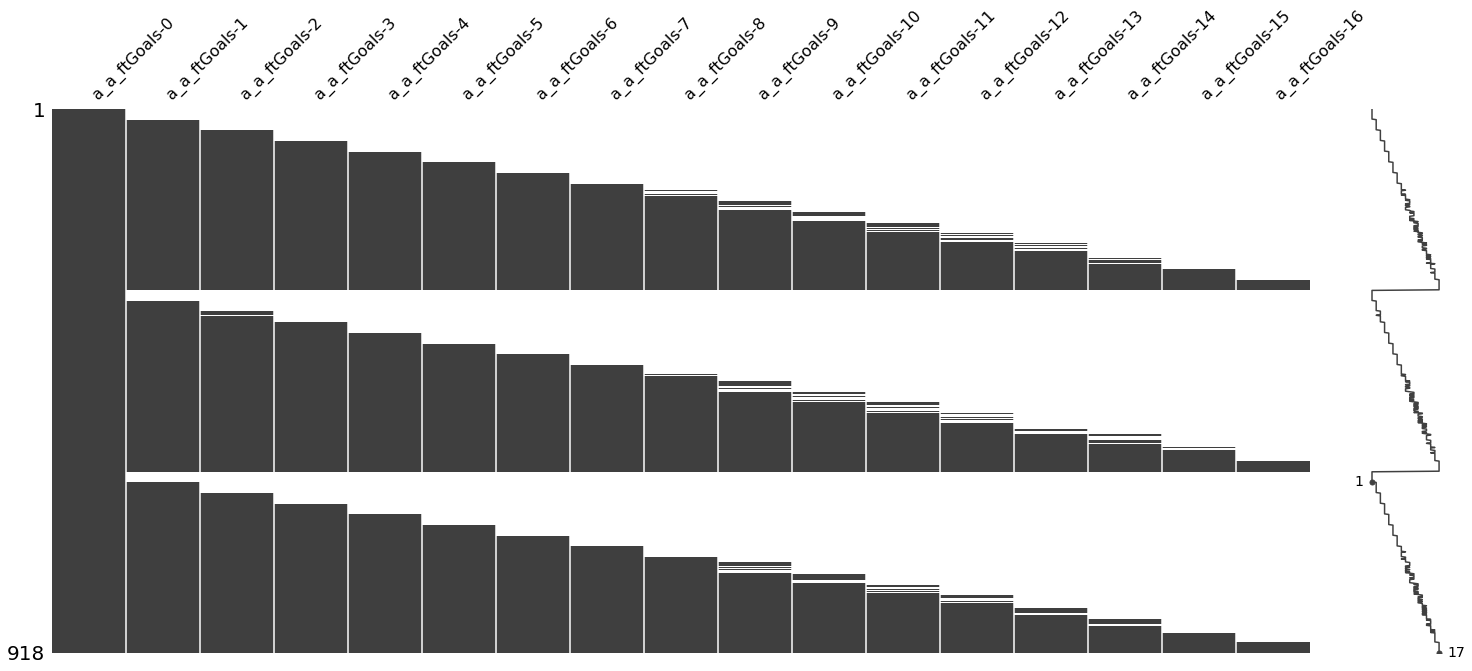

In [19]:
feat_cols = [col for col in df_trans.columns if 'a_a_ftGoals' in col]
msno.matrix(df_trans[feat_cols])
plt.show();

## 6. Select, Impute, Compress the Features

In [39]:
from src.features.manipulation import (cut_historical_games,
                                       select_features,
                                       get_feature_name_stubs,
                                       get_base_features,
                                       get_df_from_base_features)

### Pre-Process

##### Select Features

There are so many features, it is a bit overwhelming, so we will focus on a few of them for the purposes of illustrating the concepts of the modeling strategy

base_feature - ftGoals, htGoals, ...
feature_stub_set - h_h_ftGoals, a_a_ftGoals, h_a_ftGoals, a_h_ftGoals etc
feature_col_set - h_h_ftGoals-1, h_h_ftGoals-2, h_h_ftGoals-3, ..., a_h_ftGoals-16

In [37]:
base_features = get_base_features(df_trans)
base_features

['corners',
 'fouls',
 'ftGoals',
 'htGoals',
 'poissDraw',
 'poissLose',
 'poissWin',
 'redCards',
 'shots',
 'shotsOnTarget',
 'yellowCards']

In [40]:
df_select_features = get_df_from_base_features(df_trans, ['ftGoals', 'corners'])
df_select_features.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBbMax,awinOddsBbMean,awinOddsBwa,awinOddsIw,awinOddsLb,drawOdds,drawOddsBbMax,drawOddsBbMean,drawOddsBwa,drawOddsIw,drawOddsLb,h_corners,h_fouls,h_htGoals,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBbMax,hwinOddsBbMean,hwinOddsBwa,hwinOddsIw,hwinOddsLb,a_a_ftGoals-0,h_h_ftGoals-0,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_ftGoals-3,a_h_ftGoals-3,h_a_ftGoals-3,h_h_ftGoals-3,a_a_ftGoals-4,a_h_ftGoals-4,h_a_ftGoals-4,h_h_ftGoals-4,a_a_ftGoals-5,a_h_ftGoals-5,h_a_ftGoals-5,h_h_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-6,h_a_ftGoals-6,h_h_ftGoals-6,a_a_ftGoals-7,a_h_ftGoals-7,h_a_ftGoals-7,h_h_ftGoals-7,a_a_ftGoals-8,a_h_ftGoals-8,h_a_ftGoals-8,h_h_ftGoals-8,a_a_ftGoals-9,a_h_ftGoals-9,h_a_ftGoals-9,h_h_ftGoals-9,a_a_ftGoals-10,a_h_ftGoals-10,h_a_ftGoals-10,h_h_ftGoals-10,a_a_ftGoals-11,a_h_ftGoals-11,h_a_ftGoals-11,h_h_ftGoals-11,a_a_ftGoals-12,a_h_ftGoals-12,h_a_ftGoals-12,h_h_ftGoals-12,a_a_ftGoals-13,a_h_ftGoals-13,h_a_ftGoals-13,h_h_ftGoals-13,a_a_ftGoals-14,a_h_ftGoals-14,h_a_ftGoals-14,h_h_ftGoals-14,a_a_ftGoals-15,a_h_ftGoals-15,h_a_ftGoals-15,h_h_ftGoals-15,a_a_ftGoals-16,a_h_ftGoals-16,h_a_ftGoals-16,h_h_ftGoals-16,a_h_ftGoals-17,h_a_ftGoals-17,a_a_corners-0,h_h_corners-0,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_corners-3,a_h_corners-3,h_a_corners-3,h_h_corners-3,a_a_corners-4,a_h_corners-4,h_a_corners-4,h_h_corners-4,a_a_corners-5,a_h_corners-5,h_a_corners-5,h_h_corners-5,a_a_corners-6,a_h_corners-6,h_a_corners-6,h_h_corners-6,a_a_corners-7,a_h_corners-7,h_a_corners-7,h_h_corners-7,a_a_corners-8,a_h_corners-8,h_a_corners-8,h_h_corners-8,a_a_corners-9,a_h_corners-9,h_a_corners-9,h_h_corners-9,a_a_corners-10,a_h_corners-10,h_a_corners-10,h_h_corners-10,a_a_corners-11,a_h_corners-11,h_a_corners-11,h_h_corners-11,a_a_corners-12,a_h_corners-12,h_a_corners-12,h_h_corners-12,a_a_corners-13,a_h_corners-13,h_a_corners-13,h_h_corners-13,a_a_corners-14,a_h_corners-14,h_a_corners-14,h_h_corners-14,a_a_corners-15,a_h_corners-15,h_a_corners-15,h_h_corners-15,a_a_corners-16,a_h_corners-16,h_a_corners-16,h_h_corners-16,a_h_corners-17,h_a_corners-17
0,germany,bundesliga,2007-2008,stuttgart,schalke,2007-08-10,2.0,2.0,draw,0.0,23.0,1.0,NaN,NaN,NaN,0.0,10.0,4.0,3.0,2.87,3.20,2.92,2.85,2.8,3.0,3.25,3.30,3.18,3.20,3.1,3.20,9.0,19.0,0.0,NaN,NaN,NaN,0.0,16.0,7.0,4.0,2.37,2.55,2.30,2.30,2.3,2.10,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,germany,bundesliga,2007-2008,bayern-munich,hansa-rostock,2007-08-11,3.0,0.0,hwin,1.0,13.0,0.0,NaN,NaN,NaN,0.0,6.0,0.0,3.0,19.00,21.00,13.40,12.25,11.0,11.0,6.00,6.80,5.89,6.75,5.2,5.00,4.0,14.0,1.0,NaN,NaN,NaN,0.0,27.0,13.0,0.0,1.16,1.20,1.18,1.15,1.2,1.20,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Select all features for the last n games defined in `n_back`

We can either drop all games where the teams have not played, or we can impute

This is quite a big notebook, so for the sake of brevity we will drop all games unless each team has played n previous games


In [43]:
df_cut = cut_historical_games(df_select_features, n_back=2, drop_all_nan_rows=True, how='any')
df_cut.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBbMax,awinOddsBbMean,awinOddsBwa,awinOddsIw,awinOddsLb,drawOdds,drawOddsBbMax,drawOddsBbMean,drawOddsBwa,drawOddsIw,drawOddsLb,h_corners,h_fouls,h_htGoals,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBbMax,hwinOddsBbMean,hwinOddsBwa,hwinOddsIw,hwinOddsLb,a_a_ftGoals-0,h_h_ftGoals-0,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_corners-0,h_h_corners-0,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2
0,germany,bundesliga,2007-2008,dortmund,sv-werder-bremen,2007-09-14,3.0,0.0,hwin,3.0,17.0,0.0,0.222188,0.343566,0.434241,1.0,13.0,4.0,4.0,2.70,2.80,2.63,2.55,2.5,2.60,3.25,3.35,3.22,3.2,3.2,3.20,6.0,28.0,3.0,0.222188,0.434241,0.343566,0.0,6.0,5.0,2.0,2.60,2.75,2.55,2.55,2.50,2.38,0.0,3.0,1.0,2.0,1.0,3.0,2.0,0.0,1.0,1.0,3.0,6.0,3.0,6.0,6.0,7.0,6.0,5.0,0.0,6.0
1,germany,bundesliga,2007-2008,bayern-munich,schalke,2007-09-15,1.0,1.0,draw,7.0,17.0,1.0,0.057567,0.923222,0.017951,0.0,12.0,5.0,1.0,6.75,6.75,5.87,5.70,6.0,5.50,4.00,4.00,3.65,3.6,3.9,3.50,6.0,21.0,0.0,0.057567,0.017951,0.923222,0.0,14.0,6.0,1.0,1.50,1.62,1.55,1.55,1.45,1.53,1.0,1.0,1.0,1.0,1.0,3.0,2.0,4.0,4.0,3.0,7.0,6.0,8.0,6.0,6.0,7.0,0.0,8.0,6.0,4.0
2,germany,bundesliga,2007-2008,bielefeld,hansa-rostock,2007-09-15,4.0,2.0,hwin,1.0,22.0,0.0,0.151834,0.829690,0.018467,0.0,9.0,5.0,1.0,4.75,5.05,4.57,4.45,4.3,4.33,3.50,3.60,3.38,3.3,3.4,3.40,4.0,18.0,1.0,0.151834,0.018467,0.829690,0.0,14.0,7.0,0.0,1.75,1.85,1.74,1.75,1.70,1.67,2.0,4.0,0.0,0.0,0.0,2.0,0.0,1.0,3.0,2.0,1.0,4.0,4.0,5.0,5.0,4.0,1.0,5.0,7.0,3.0
3,germany,bundesliga,2007-2008,eintracht-frankfurt,hamburger-sv,2007-09-15,2.0,1.0,hwin,10.0,18.0,0.0,0.354313,0.224404,0.421283,0.0,17.0,7.0,4.0,2.60,2.65,2.53,2.50,2.5,2.40,3.25,3.30,3.20,3.2,3.2,3.25,3.0,21.0,1.0,0.354313,0.421283,0.224404,0.0,16.0,4.0,1.0,2.70,2.90,2.62,2.60,2.50,2.50,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,10.0,3.0,6.0,5.0,1.0,9.0,4.0,6.0,8.0,6.0
4,germany,bundesliga,2007-2008,leverkusen,bochum,2007-09-15,2.0,0.0,hwin,9.0,21.0,0.0,0.138022,0.764878,0.096902,1.0,11.0,4.0,1.0,5.50,5.65,5.07,4.60,4.8,4.50,3.75,3.80,3.51,3.4,3.6,3.50,8.0,18.0,0.0,0.138022,0.096902,0.764878,0.0,21.0,4.0,2.0,1.61,1.73,1.65,1.70,1.60,1.62,0.0,2.0,2.0,2.0,1.0,3.0,2.0,2.0,0.0,0.0,9.0,8.0,4.0,4.0,4.0,9.0,3.0,7.0,4.0,7.0


In [44]:
df_cut.shape

(808, 67)

Select full time goals and poisson regression probabilities

In [ ]:
feature_name_stubs = get_geature_name_stubs()

In [23]:
#Just use the goal scored data
feature_name_stubs = list(set([col.rsplit('-',1)[0] for col in df_trans.columns if 'ftGoals' in col and '-' in col]))
feature_name_stubs

['a_h_ftGoals', 'h_a_ftGoals', 'h_h_ftGoals', 'a_a_ftGoals']

In [32]:
sorted(list(set([col.rsplit('-',1)[0][2:] for col in df_trans.columns if '-' in col])))

['a_corners',
 'a_fouls',
 'a_ftGoals',
 'a_htGoals',
 'a_poissDraw',
 'a_poissLose',
 'a_poissWin',
 'a_redCards',
 'a_shots',
 'a_shotsOnTarget',
 'a_yellowCards',
 'h_corners',
 'h_fouls',
 'h_ftGoals',
 'h_htGoals',
 'h_poissDraw',
 'h_poissLose',
 'h_poissWin',
 'h_redCards',
 'h_shots',
 'h_shotsOnTarget',
 'h_yellowCards']

In [ ]:
df_model = df_trans2.copy(deep=True)

def cut_historical_games(df_orig, n_back, drop_all_nan_rows=True, how='all'):
    
    df = df_orig.copy(deep=True)
    feature_cols = [col for col in df.columns if '-' in col]
    non_feature_cols = [col for col in df.columns if col not in feature_cols]
    cut_feature_cols = [col for col in feature_cols if int(col.rsplit('-')[1]) <= n_back]
    return_cols = non_feature_cols + cut_feature_cols
    df = df[return_cols]
    if drop_all_nan_rows:
        df.dropna(subset=cut_feature_cols, axis=0, inplace=True, how=how)
    df.reset_index(drop=True, inplace=True)
    return df
    
n_back=4

df_lastn = cut_historical_games(df_model, n_back=n_back, drop_all_nan_rows=False)
df_lastn.head()

##### Cut the Number of Features

In [ ]:
def get_non_feature_cols(df):
    non_feature_cols = [col for col in df.columns if '-' not in col]
    return non_feature_cols

def get_all_feature_cols(df):
    all_feature_cols = [col for col in df.columns if '-' in col]
    return all_feature_cols

#feature_cols = get_all_feature_cols(df_last4)
#my_feature_cols = [col for col in df_lastn.columns if 'poiss' in col or 'shots' in col or 'ftGoals' in col]
# my_feature_cols = [col for col in df_lastn.columns if 'shotsOnTarget' in col]
my_feature_cols = [col for col in df_lastn.columns if 'ftGoals' in col]
#my_feature_cols = [col for col in df_lastn.columns if 'shots' in col]
#my_feature_cols = [col for col in df_lastn.columns if 'poiss' in col]
non_feature_cols = get_non_feature_cols(df_lastn)

keeper_cols = non_feature_cols + my_feature_cols
df_lastn_feat = df_lastn[keeper_cols].copy(deep=True)

In [20]:
stop

NameError: name 'stop' is not defined

Put the features into order and take a look at the shape of the data

In [ ]:
def get_feature_cols(df):
    features = sorted(list(set([col.split('-')[0] for col in df.columns if '-' in col])))
    return features

def get_sorted_feature_cols(df):
    # Grab the feature names
    #features = sorted(list(set([col.split('-')[0] for col in df.columns if '-' in col])))
    features = get_feature_cols(df)
    features_list = []
    for feature in features:
        unsorted_feature_list = [col for col in df.columns if feature == col.rsplit('-',1)[0]]
        unsorted_feature_list.sort(key=lambda x: int(x.rsplit('-',1)[1]))
        features_list.extend(unsorted_feature_list)
    return features_list
    
sorted_feature_cols = get_sorted_feature_cols(df_trans)
other_cols = [col for col in df.columns if col not in sorted_feature_cols]
all_cols = other_cols + sorted_feature_cols
#+ ['hwinOddsBet365', 'drawOddsBet365', 'awinOddsBet365',
#                                      'hwinOddsLb', 'drawOddsLb', 'awinOddsLb']
#all_cols = extend_cols(defined_cols)

In [ ]:
df_trans2 = df_trans[all_cols].copy(deep=True)
df_trans2.head(2)

In [ ]:
drop_cols = [col for col in df_trans2.columns if '-' in col and int(col.rsplit('-')[1]) == 0]
df_trans2.drop(columns=drop_cols, inplace=True)
df_trans2.info(verbose=True, null_counts=True)

## 5. Model the Transformed Data

In [ ]:
df_lastn.shape

In [ ]:
df_lastn = cut_historical_games(df_model, n_back=n_back, drop_all_nan_rows=True, how='any')
df_lastn.head()

In [ ]:
df_lastn.shape

In [ ]:
df_lastn_feat.head()

In [ ]:
df_lastn_feat.shape

In [ ]:
# Just the feature columns
df_lastn_feat[my_feature_cols].shape

### Model

In [ ]:
df_pre_model = df_lastn_feat.copy(deep=True)

In [ ]:
def calc_rps_ss(rps: pd.Series, rps_b: pd.Series):
    """
    Accepts two Series - must be same length
    rps contains rank probability scores for individual events
    rps_b contains benchmark rank probability scores for individual events
    Return the Rank Probability Skill Score for each event as a Series
    """
    RPS_SS = 1 - (rps / rps_b)
    return RPS_SS
    
#df_coded['RPS_SS'] = calc_rps_ss(df_coded['hist_RPS'], df_coded['pinn_RPS'])

#df_coded.head()

In [ ]:
def calc_rps(pred_df: pd.DataFrame, obs_df: pd.DataFrame):
    """
    Accepts two DataFrames - DataFrames must be same size
    pred_df contains probability predictions of outcomes in ranked order
    obs_df contains 0 or 1 based on the observed outcome where the 
    outcomes are in the same ranked order
    Return the Rank Probability Score for each row inside a series
    """
    #print(pred_df.values)
    pred_cdf = pred_df.cumsum(axis=1).values
    # print(pred_cdf)
    obs_cdf = obs_df.cumsum(axis=1).values
    # RPS = (pred_cdf - obs_cdf)**2
    #RPS = pd.Series(np.sum(1/(pred_df.shape[1]-1) * (pred_cdf - obs_cdf)**2, 1), name='RPS')
    return np.sum(1/(pred_df.shape[1]-1) * (pred_cdf - obs_cdf)**2, 1)
    # print(RPS[0:5])
    #return RPS
    
# RPS = calc_rps(df_test[['p1','p2', 'p3']], df_test[['obs_cat1','obs_cat2', 'obs_cat3']])
# print(f'RPS vector:\n{RPS}\n')
    
# mean_RPS = RPS.mean()
# print(f'Mean RPS: {mean_RPS}\n')

# gmean_RPS = stats.gmean(RPS)
# # print(f'Geometric Mean RPS: {gmean_RPS}\n')

# hmean_RPS = stats.hmean(RPS)
# # print(f'Harmonic Mean RPS: {hmean_RPS}\n')

# sum_RPS = RPS.sum()
# print(f'Sum RPS: {sum_RPS}')

In [ ]:
# Test Data form Met Office? Online Course Page - Computation of the Rank Probability Score (RPS) – Accuracy

d = {'p1': [0.7, 0.9, 0.9, 0.8, 0.8, 0.9, 0.6, 0.3, 0.3,0.8, 0.8, 0.0, 0.3],
     'p2': [0.3, 0.1, 0.1, 0.2, 0.2, 0.1, 0.4, 0.4, 0.4, 0.2, 0.2, 0.4, 0.7],
     'p3': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.3, 0.0, 0.0, 0.6, 0.0],
     'obs_cat': [1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 3 ,2],
     'obs_cat1': [1,1,1,1,1,1,0,0,1,1,0,0,0],
     'obs_cat2': [0,0,0,0,0,0,1,1,0,0,1,0,1],
     'obs_cat3': [0,0,0,0,0,0,0,0,0,0,0,1,0],
     'rps': [0.045, 0.005, 0.005, 0.020, 0.020, 0.005, 0.180, 0.090, 0.29, 0.020, 0.320, 0.080, 0.045]}
df_test = pd.DataFrame(d)
df_test.head(20)

In [ ]:
RPS = calc_rps(df_test[['p1','p2', 'p3']], df_test[['obs_cat1','obs_cat2', 'obs_cat3']])
print(f'RPS vector:\n{RPS}\n')

In [ ]:
df_pre_model.head()

In [ ]:
df_pre_model.tail()

### Prepare the DataFrame for Modeling

We will be using a Rank probability Score to assess our models, therefore we have to ensure we have the right ordinality between home win, draw and away win

In [ ]:
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder

ord_enc = OrdinalEncoder(mapping = [{'col': 'result', 'mapping': {'hwin': 1, 'draw': 2, 'awin': 3}}])
df_pre_model['ordinal_result'] = ord_enc.fit_transform(df_pre_model[['result']])#ordinal_encoding(df_pre_model)

one_hot_enc = OneHotEncoder(cols=['ordinal_result'], use_cat_names=True)
one_hot_cols = one_hot_enc.fit_transform(df_pre_model[['ordinal_result']])
new_one_hot_col_names = [col[:-2] for col in one_hot_cols.columns]
mapping_dict = {old: new for old, new in zip(one_hot_cols.columns, new_one_hot_col_names)}
one_hot_cols.rename(columns=mapping_dict, inplace=True)
one_hot_cols = one_hot_cols[sorted(one_hot_cols.columns)]
#one_hot_columns = sorted([col for col in one_hot_cols.columns])
# one_hot_cols = one_hot_cols[sorted(one_hot_cols.columns)]
# one_hot_columns = [col[:-2] for col in one_hot_cols.columns]
# one_hot_cols = one_hot_cols[one_hot_columns]

df_all_cols = pd.concat([df_pre_model, one_hot_cols], axis=1)

df_all_cols.head(13)

Prior to modeling, we will split the DataFrame into 3 parts, all keeping the same row index
+ meta - all meta data
+ X - all features
+ y - target

In [ ]:
df = df_all_cols.copy(deep=True)
all_features = get_all_feature_cols(df)
X = df[all_features].copy(deep=True)
X.head(2)

In [ ]:
non_feature_cols = get_non_feature_cols(df)
meta = df[non_feature_cols].copy(deep=True)
meta.head(2)

In [ ]:
#y = df[['ordinal_result_1', 'ordinal_result_2', 'ordinal_result_3']].copy(deep=True)
y = df['ordinal_result']
y.head(2)

In [ ]:
# from keras.utils import to_categorical
# yc = to_categorical(y.values)
# yc


In [ ]:
# yc.shape

### Model

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [ ]:
# Split into Train, test, but we will also split the additional data for meta data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
meta_train = meta.loc[y_train.index, :]
meta_test = meta.loc[y_test.index, :]
# print(f'train index:{X_train.index}')
# print(f'meta_train index:{meta_train.index}\n')
# print(f'test index: {y_test.index}')
# print(f'meta test index: {meta_test.index}')
X = X_train.copy(deep=True)
y = y_train.copy(deep=True)

In [ ]:
X.head(2)

In [ ]:
y.head(2)

In [ ]:
meta_train.head(2)

In [ ]:
# https://stackoverflow.com/questions/48508036/
# sklearn-stratifiedkfold-valueerror-supported-target-types-are-binary-mul/51795404#51795404
skf = StratifiedKFold(n_splits=2,shuffle=True)
# clf = MultinomialNB(class_prior=[0.45, 0.25, 0.30])
#clf = CategoricalNB(class_prior=[0.45, 0.25, 0.30])
# clf = RandomForestClassifier(max_depth=15, class_weight='balanced')
clf = GradientBoostingClassifier(n_estimators=100,learning_rate=0.1, max_depth=4)
#clf = LinearDiscriminantAnalysis(priors=[0.45, 0.25, 0.30])
# clf = LogisticRegression(class_weight='balanced', C=0.1)
# clf = ExtraTreesClassifier(class_weight='balanced')


X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
meta_train = meta_train.reset_index(drop=True)

joined_validate_dfs = []
n = 0
for fit_indices, validate_indices in skf.split(X, y):

    X_fit = X.iloc[fit_indices]
    y_fit = y.iloc[fit_indices]
    
    X_validate = X.iloc[validate_indices]
    y_validate = y.iloc[validate_indices]
    
    meta_fit = meta.iloc[fit_indices]
    meta_validate = meta.iloc[validate_indices]
    
    clf.fit(X_fit, y_fit)
    validate_preds = clf.predict_proba(X_validate)
    
    validate_preds_df = pd.DataFrame(validate_preds, columns = clf.classes_, index=validate_indices)
    
    df_validate = pd.concat([meta_validate, X_validate, validate_preds_df], sort=False, axis=1)
    df_validate['model_rps'] = calc_rps(validate_preds_df,
                                        meta_validate[['ordinal_result_1','ordinal_result_2', 'ordinal_result_3']])
    df_validate['bookie_rps'] = calc_rps(meta_validate[['implied_hwin', 'implied_draw', 'implied_awin']],
                                         meta_validate[['ordinal_result_1','ordinal_result_2', 'ordinal_result_3']])
    df_validate['rpss'] = calc_rps_ss(df_validate['model_rps'], df_validate['bookie_rps'])
                                  #meta_validate[['ordinal_result_1','ordinal_result_2', 'ordinal_result_3']])
    df_validate['n_fold'] = n
    n += 1
    
    joined_validate_dfs.append(df_validate)




validation_df = pd.concat(joined_validate_dfs, sort=False, axis=0)


In [ ]:
# clf.feature_importances_

In [ ]:
joblib.dump(clf, SAMP_MODEL_FP) 

In [ ]:
validation_df.head(5)

In [ ]:
validation_df.tail(5)

In [ ]:
validation_df.info()

In [ ]:
output_df = validation_df.copy(deep=True)
output_df.reset_index(drop=True, inplace=True)

## Simulate Gambling in Validation Data

In [ ]:
output_df.head()

In [ ]:
### Identify Poistive EV Bets

In [ ]:
output_df['hwin_unit_EV'] = (output_df[1]* (output_df['hwinOddsBet365']-1)) + ((1- output_df[1]) * -1)
output_df['draw_unit_EV'] = (output_df[2]* (output_df['drawOddsBet365']-1)) + ((1- output_df[2]) * -1)
output_df['awin_unit_EV'] = (output_df[3]* (output_df['awinOddsBet365']-1)) + ((1- output_df[3]) * -1)
output_df.head()

In [ ]:
threshold = 0.05
output_df[['hwin_bet', 'draw_bet', 'awin_bet']] = \
            output_df[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= threshold
output_df.head()

In [ ]:
conditions = [output_df['ordinal_result_1'] == 1,
              output_df['ordinal_result_1'] == 0]
choices = [(output_df['hwinOddsBet365']-1)* output_df['hwin_bet'], -1* output_df['hwin_bet']]
output_df['hwin_rets'] = np.select(conditions, choices, default=0)

conditions = [output_df['ordinal_result_2'] == 1,
              output_df['ordinal_result_2'] == 0]
choices = [(output_df['drawOddsBet365']-1)* output_df['draw_bet'], -1* output_df['draw_bet']]
output_df['draw_rets'] = np.select(conditions, choices, default=0)

conditions = [output_df['ordinal_result_3'] == 1,
              output_df['ordinal_result_3'] == 0]
choices = [(output_df['awinOddsBet365']-1)* output_df['awin_bet'], -1* output_df['awin_bet']]
output_df['awin_rets'] = np.select(conditions, choices, default=0)
output_df['game_ret'] = output_df[['hwin_rets', 'draw_rets', 'awin_rets']].sum(axis=1)

output_df.head(10)

In [ ]:
output_df['hwin_rets'].sum()

In [ ]:
output_df['draw_rets'].sum()

In [ ]:
output_df['awin_rets'].sum()

In [ ]:
output_df[['hwin_rets', 'draw_rets', 'awin_rets']].sum(axis=1).sum()

In [ ]:
output_df['rpss'].sum() / len(output_df)

## Simulate Gambling in Test Data

#### Load the Optimized Model

In [ ]:
clf = joblib.load(SAMP_MODEL_FP)
clf

In [ ]:
meta_t = meta_test.copy(deep=True)
X_t = X_test.copy(deep=True)
y_t = y_test.copy(deep=True)

meta_t.reset_index(drop=True, inplace=True)
X_t.reset_index(drop=True, inplace=True)
y_t.reset_index(drop=True, inplace=True)

In [ ]:
meta_t.head(2)

In [ ]:
X_t.head(2)

In [ ]:
y_t.head(2)

In [ ]:
test_preds = clf.predict_proba(X_t)
test_preds_df = pd.DataFrame(test_preds, columns = clf.classes_)
df_test = pd.concat([meta_t, X_t, test_preds_df], sort=False, axis=1)
df_test['model_rps'] = calc_rps(test_preds_df,
                                meta_t[['ordinal_result_1','ordinal_result_2', 'ordinal_result_3']])
df_test['bookie_rps'] = calc_rps(meta_t[['implied_hwin', 'implied_draw', 'implied_awin']],
                                 meta_t[['ordinal_result_1','ordinal_result_2', 'ordinal_result_3']])
df_test['rpss'] = calc_rps_ss(df_test['model_rps'], df_test['bookie_rps'])

In [ ]:
df_test['hwin_unit_EV'] = (df_test[1]* (df_test['hwinOddsBet365']-1)) + ((1- df_test[1]) * -1)
df_test['draw_unit_EV'] = (df_test[2]* (df_test['drawOddsBet365']-1)) + ((1- df_test[2]) * -1)
df_test['awin_unit_EV'] = (df_test[3]* (df_test['awinOddsBet365']-1)) + ((1- df_test[3]) * -1)
df_test.head()

In [ ]:
threshold = threshold
df_test[['hwin_bet', 'draw_bet', 'awin_bet']] = \
            df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= threshold
df_test.head()

In [ ]:
# made the bet
# Get bet result

conditions = [df_test['ordinal_result_1'] == 1,
              df_test['ordinal_result_1'] == 0]
choices = [(df_test['hwinOddsBet365']-1)* df_test['hwin_bet'], -1* df_test['hwin_bet']]
df_test['hwin_rets'] = np.select(conditions, choices, default=0)

conditions = [df_test['ordinal_result_2'] == 1,
              df_test['ordinal_result_2'] == 0]
choices = [(df_test['drawOddsBet365']-1)* df_test['draw_bet'], -1* df_test['draw_bet']]
df_test['draw_rets'] = np.select(conditions, choices, default=0)

conditions = [df_test['ordinal_result_3'] == 1,
              df_test['ordinal_result_3'] == 0]
choices = [(df_test['awinOddsBet365']-1)* df_test['awin_bet'], -1* df_test['awin_bet']]
df_test['awin_rets'] = np.select(conditions, choices, default=0)
df_test['game_ret'] = df_test[['hwin_rets', 'draw_rets', 'awin_rets']].sum(axis=1)

df_test.head(10)

In [ ]:
df_test[df_test['game_ret'] != 0].head(20)

In [ ]:
print(df_test['hwin_rets'].sum())
print(df_test['draw_rets'].sum())
print(df_test['awin_rets'].sum())
print()
print(f"Total profit/loss: {df_test[['hwin_rets', 'draw_rets', 'awin_rets']].sum(axis=1).sum()}")

In [ ]:
print(f"n_bets: {df_test[['hwin_bet', 'draw_bet', 'awin_bet']].sum(axis=1).sum()}")
print(f"n_games: {len(df_test)}")
print(f"Unit Ret per Game: {df_test['game_ret'].sum()/ len(df_test)}")
print(f"Unit Ret per Bet: {df_test['game_ret'].sum()/ df_test[['hwin_bet', 'draw_bet', 'awin_bet']].sum(axis=1).sum()}")

In [ ]:
df_test['rpss'].sum() / len(df_test)